Import the necessary libraries

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse

Import dataset

In [18]:
file_path = "reddit_posts.csv"
df = pd.read_csv(r"D:\Data_Science\Project\Reddit_EDA\reddit_data.csv")
print(df.shape)

(22497, 15)


Display the first 5 rows of the dataset

In [19]:
df.head(5)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22497 entries, 0 to 22496
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            22497 non-null  object 
 1   Title         22497 non-null  object 
 2   Score         22497 non-null  int64  
 3   Author        22497 non-null  object 
 4   Created_UTC   22497 non-null  float64
 5   Comments      22497 non-null  int64  
 6   Domain        22497 non-null  object 
 7   URL           22497 non-null  object 
 8   Subreddit     22497 non-null  object 
 9   Upvote_Ratio  22497 non-null  float64
 10  NSFW          22497 non-null  bool   
 11  Flair         9147 non-null   object 
 12  Is_Self       22497 non-null  bool   
 13  Crossposts    22497 non-null  int64  
 14  Permalink     22497 non-null  object 
dtypes: bool(2), float64(2), int64(3), object(8)
memory usage: 2.3+ MB


Standardize columns

In [20]:
df.columns = (df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^a-z0-9]+", "_", regex=True)
              .str.strip("_"))

expected = ["id","title","score","author","created_utc","comments","domain","url",
            "subreddit","upvote_ratio","nsfw","flair","is_self","crossposts","permalink"]
df = df[[c for c in expected if c in df.columns]]

Data cleaning

In [31]:
for c in ["score","comments","upvote_ratio","crossposts","created_utc"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "upvote_ratio" in df.columns:
    df["upvote_ratio"] = df["upvote_ratio"].clip(0,1)

for b in ["nsfw","is_self"]:
    if b in df.columns:
        df[b] = df[b].astype(str).str.lower().map({"true": True, "false": False})

for cat in ["subreddit","flair","domain","author"]:
    if cat in df.columns:
        df[cat] = df[cat].astype("category")


# Time features from Unix epoch (seconds). Switch to unit='ms' if needed.
if "created_utc" in df.columns:
    df["created_dt"] = pd.to_datetime(df["created_utc"], unit="s", errors="coerce")
    df["date"] = df["created_dt"].dt.date
    df["hour"] = df["created_dt"].dt.hour
    df["weekday"] = df["created_dt"].dt.day_name()
    df["week"] = df["created_dt"].dt.isocalendar().week.astype("Int64")
    df["year"] = df["created_dt"].dt.year

# Fill/derive domain from URL
if "url" in df.columns:
    parsed = df["url"].dropna().apply(lambda u: urlparse(u).netloc.lower())
    if "domain" not in df.columns:
        df["domain"] = parsed
    else:
        df["domain"] = df["domain"].astype(str).str.lower()
        df.loc[df["domain"].isin(["", "nan", "none"]), "domain"] = parsed
    df["domain"] = df["domain"].astype("category")



if "flair" in df.columns:
    flair_filled = df["flair"].astype("string")  
    flair_filled = flair_filled.fillna("Unflair")
    df["flair_filled"] = flair_filled.astype("category")

top_flair = (df.groupby("flair_filled", dropna=False)
               .agg(count=("id","count"), med_score=("score","median"))
               .sort_values("count", ascending=False)
               .head(20)
               .reset_index())

print("Rows, Cols:", df.shape)
df.head(3)

Rows, Cols: (22497, 22)


,id,title,score,author,created_utc,comments,domain,url,subreddit,upvote_ratio,...,is_self,crossposts,permalink,created_dt,date,hour,weekday,week,year,flair_filled
0,1mnyo3f,/r/WorldNews Live Thread: Russian Invasion of ...,49,WorldNewsMods,1.754971e+09,5,reddit.com,https://www.reddit.com/live/18hnzysb1elcs,worldnews,0.93,...,False,0,/r/worldnews/comments/1mnyo3f/rworldnews_live_...,2025-08-12 04:02:34,2025-08-12,4,Tuesday,33,2025,Russia/Ukraine
1,1mnofvu,Ukrainian drones reportedly strike Russian oil...,4907,CrunchyBaconYum,1.754945e+09,77,tvpworld.com,https://tvpworld.com/88272630/ukrainian-drones...,worldnews,0.98,...,False,1,/r/worldnews/comments/1mnofvu/ukrainian_drones...,2025-08-11 20:37:17,2025-08-11,20,Monday,33,2025,Russia/Ukraine
2,1mnehyc,EU to channel $1.7 billion from frozen Russian...,16739,BreakfastTop6899,1.754923e+09,207,kyivindependent.com,https://kyivindependent.com/eu-to-channel-1-7-...,worldnews,0.97,...,False,1,/r/worldnews/comments/1mnehyc/eu_to_channel_17...,2025-08-11 14:28:27,2025-08-11,14,Monday,33,2025,Russia/Ukraine


In [32]:

print(df.isna().sum())

id              0
title           0
score           0
author          0
created_utc     0
comments        0
domain          0
url             0
subreddit       0
upvote_ratio    0
nsfw            0
flair           0
is_self         0
crossposts      0
permalink       0
created_dt      0
date            0
hour            0
weekday         0
week            0
year            0
flair_filled    0
dtype: int64


# Data understanding

In [ ]:
print(df.info())
print(df.describe(include='all', datetime_is_numeric=True).T)

In [34]:
#Q1. What is the dataset’s structure and missingness?
print(df.info())
print("\nMissing values:\n", df.isna().sum().sort_values(ascending=False))
print("\nUnique counts:\n", df.nunique().sort_values())
mem_mb = df.memory_usage(deep=True).sum()/(1024**2)
print(f"\nEstimated memory: {mem_mb:.2f} MB")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22497 entries, 0 to 22496
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            22497 non-null  object        
 1   title         22497 non-null  object        
 2   score         22497 non-null  int64         
 3   author        22497 non-null  category      
 4   created_utc   22497 non-null  float64       
 5   comments      22497 non-null  int64         
 6   domain        22497 non-null  category      
 7   url           22497 non-null  object        
 8   subreddit     22497 non-null  category      
 9   upvote_ratio  22497 non-null  float64       
 10  nsfw          22497 non-null  bool          
 11  flair         22497 non-null  category      
 12  is_self       22497 non-null  bool          
 13  crossposts    22497 non-null  int64         
 14  permalink     22497 non-null  object        
 15  created_dt    22497 non-null  dateti

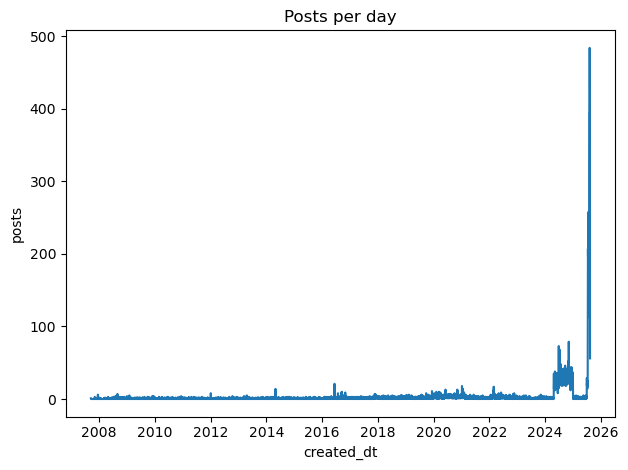

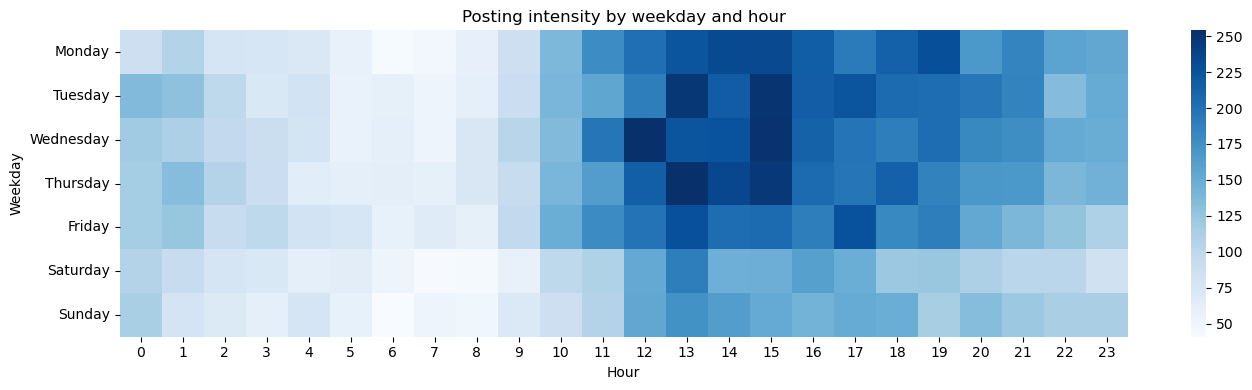

In [35]:
#Q2. When are posts created? Daily/weekly activity patterns?
if "created_dt" in df.columns:
    daily = (df.dropna(subset=["created_dt"])
               .groupby(pd.Grouper(key="created_dt", freq="D"))
               .size().rename("posts").reset_index())

    ax = sns.lineplot(data=daily, x="created_dt", y="posts", color="tab:blue")
    ax.set_title("Posts per day")
    plt.tight_layout(); plt.show()

    if {"weekday","hour"}.issubset(df.columns):
        heat = (df.dropna(subset=["weekday","hour"])
                  .groupby(["weekday","hour"]).size()
                  .reset_index(name="count"))
        order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
        heat["weekday"] = pd.Categorical(heat["weekday"], categories=order, ordered=True)
        pivot = heat.pivot(index="weekday", columns="hour", values="count").fillna(0)
        plt.figure(figsize=(14,4))
        sns.heatmap(pivot, cmap="Blues")
        plt.title("Posting intensity by weekday and hour")
        plt.xlabel("Hour"); plt.ylabel("Weekday")
        plt.tight_layout(); plt.show()


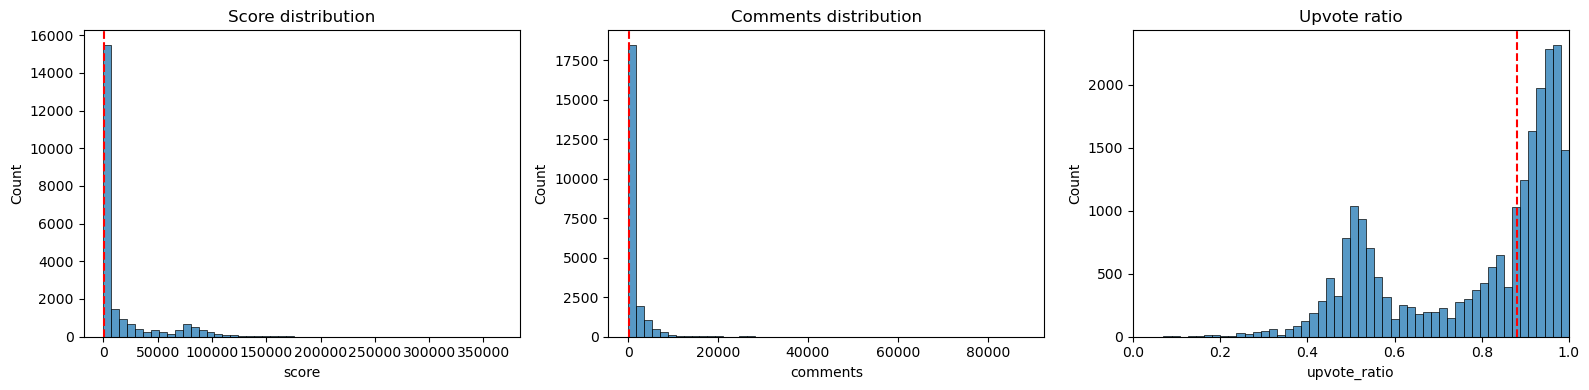

In [39]:
#What do score, comments, and upvote_ratio look like?
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Score
if "score" in df.columns:
    sns.histplot(df["score"].dropna(), bins=50, ax=axes[0])
    axes[0].axvline(df["score"].median(), color="red", ls="--")
    axes[0].set_title("Score distribution")

# Comments
if "comments" in df.columns:
    sns.histplot(df["comments"].dropna(), bins=50, ax=axes[1])
    axes[1].axvline(df["comments"].median(), color="red", ls="--")
    axes[1].set_title("Comments distribution")

# Upvote ratio
if "upvote_ratio" in df.columns:
    sns.histplot(df["upvote_ratio"].dropna(), bins=50, ax=axes[2])
    axes[2].axvline(df["upvote_ratio"].median(), color="red", ls="--")
    axes[2].set_xlim(0, 1)
    axes[2].set_title("Upvote ratio")

plt.tight_layout()
plt.show()


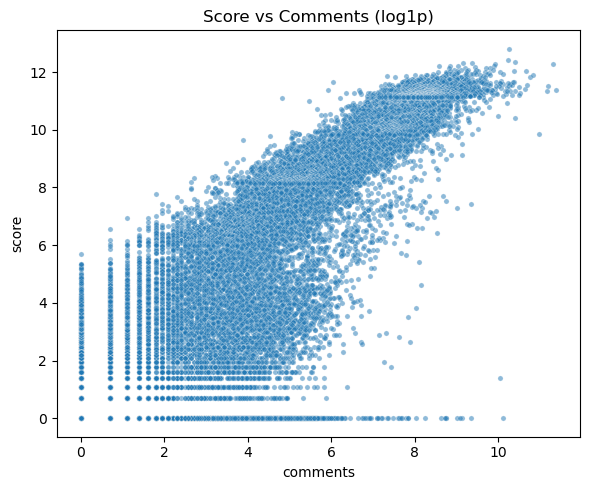

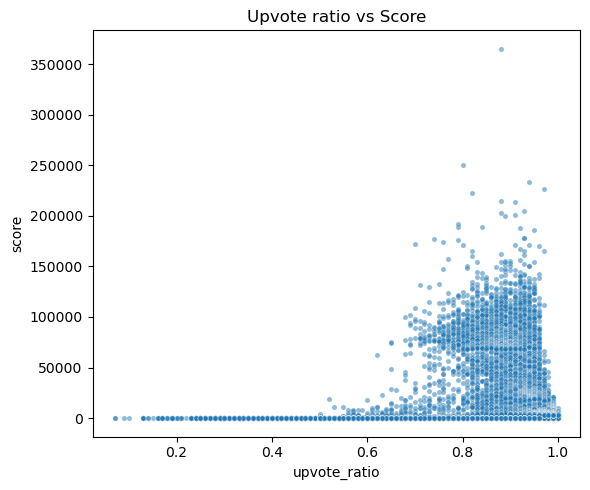

In [40]:
#Q4. Are scores correlated with comments and upvote_ratio?
# Score vs Comments (log1p)
if {"score","comments"}.issubset(df.columns):
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=np.log1p(df["comments"]), y=np.log1p(df["score"]), s=14, alpha=0.5)
    plt.title("Score vs Comments (log1p)"); plt.tight_layout(); plt.show()

# Upvote ratio vs Score (descriptive only)
if {"upvote_ratio","score"}.issubset(df.columns):
    plt.figure(figsize=(6,5))
    sns.scatterplot(data=df.dropna(subset=["upvote_ratio","score"]),
                    x="upvote_ratio", y="score", s=14, alpha=0.5)
    plt.title("Upvote ratio vs Score"); plt.tight_layout(); plt.show()


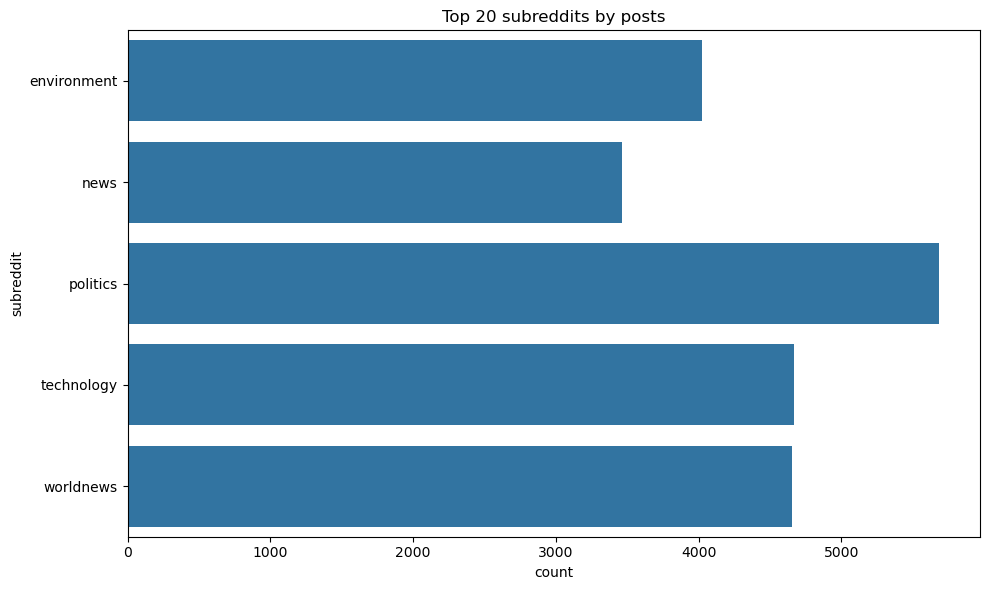

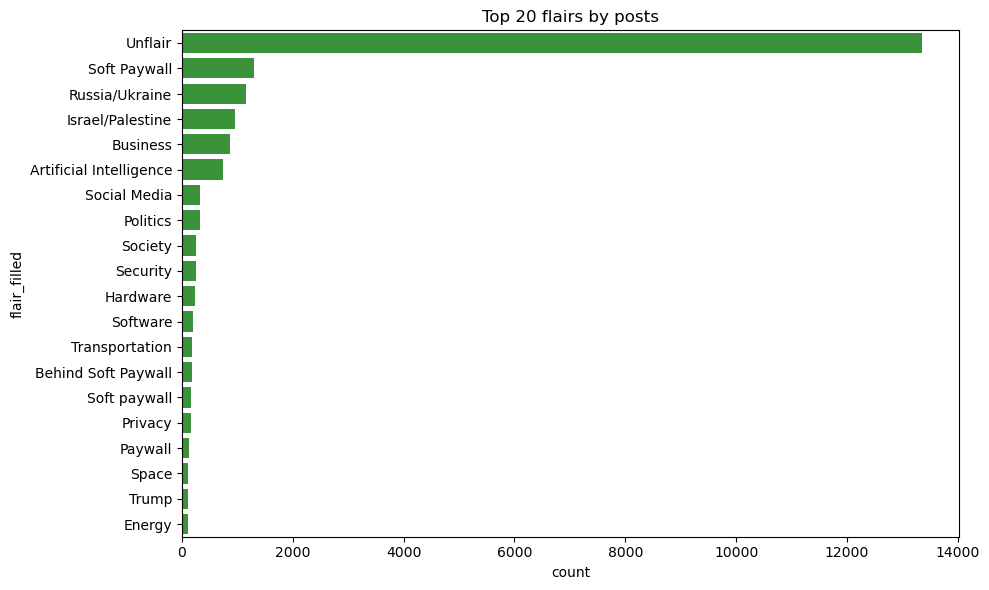

In [41]:
#Q5. Which subreddits and flairs dominate?
if "subreddit" in df.columns:
    top_sub = (df.groupby("subreddit")
                 .agg(count=("id","count"), med_score=("score","median"))
                 .sort_values("count", ascending=False).head(20).reset_index())
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_sub, y="subreddit", x="count", color="tab:blue")
    plt.title("Top 20 subreddits by posts")
    plt.tight_layout(); plt.show()

if "flair" in df.columns:
    df["flair_filled"] = df["flair"].astype(str).replace({"nan":"Unflair","None":"Unflair","": "Unflair"})
    top_flair = (df.groupby("flair_filled")
                   .agg(count=("id","count"), med_score=("score","median"))
                   .sort_values("count", ascending=False).head(20).reset_index())
    plt.figure(figsize=(10,6))
    sns.barplot(data=top_flair, y="flair_filled", x="count", color="tab:green")
    plt.title("Top 20 flairs by posts")
    plt.tight_layout(); plt.show()


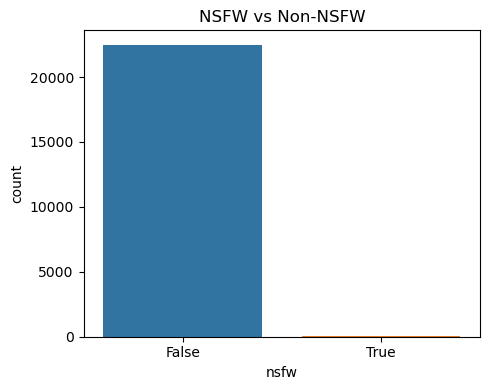

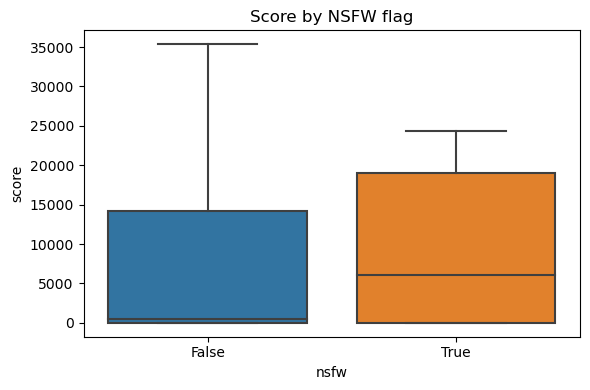

In [42]:
#Q6. How does NSFW content differ?
if "nsfw" in df.columns:
    plt.figure(figsize=(5,4))
    sns.countplot(data=df, x="nsfw")
    plt.title("NSFW vs Non-NSFW")
    plt.tight_layout(); plt.show()

    if "score" in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x="nsfw", y="score", showfliers=False)
        plt.title("Score by NSFW flag")
        plt.tight_layout(); plt.show()


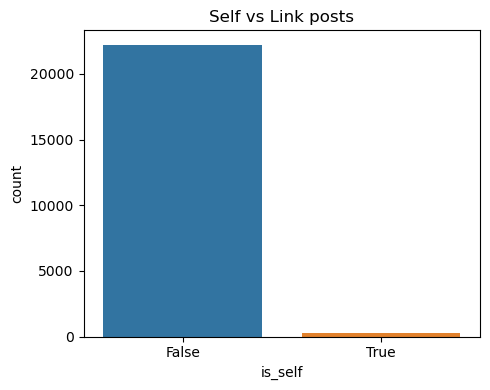

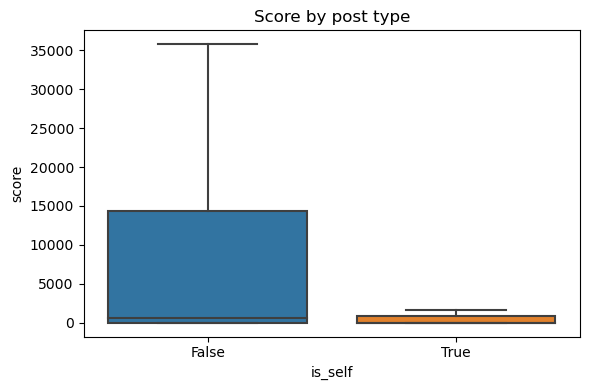

In [43]:
#Q7. Self posts vs link posts: volume and engagement?
if "is_self" in df.columns:
    plt.figure(figsize=(5,4))
    sns.countplot(data=df, x="is_self")
    plt.title("Self vs Link posts")
    plt.tight_layout(); plt.show()

    if "score" in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x="is_self", y="score", showfliers=False)
        plt.title("Score by post type")
        plt.tight_layout(); plt.show()


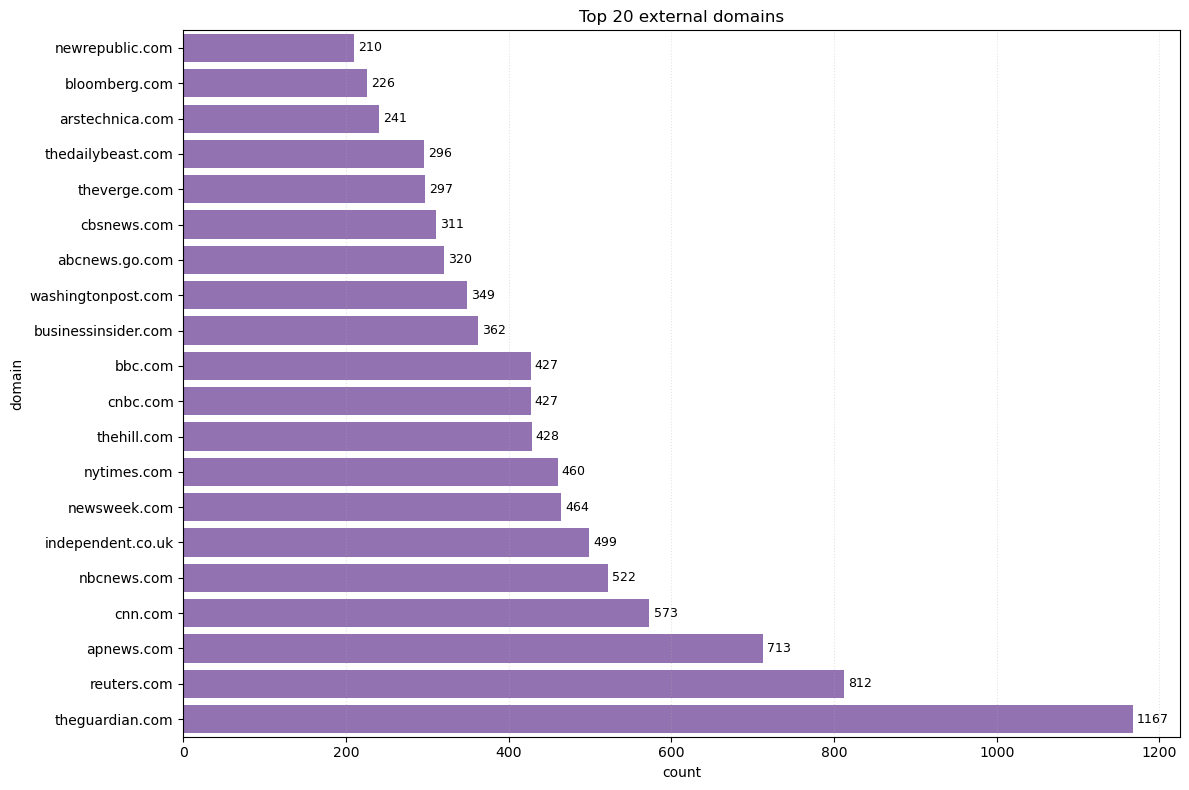

In [46]:
def is_internal(d):
    d = str(d).lower()
    return ("reddit.com" in d) or ("redd.it" in d)

if "domain" in df.columns:
    # 1) Clean domain values
    dom = (
        df["domain"]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"^www\d*\.", "", regex=True)      # drop www., www2., etc.
        .str.replace(r"/.*$", "", regex=True)           # drop path fragments if any slipped in
    )

    # 2) Keep only external and non-empty domains
    ext = dom[dom.ne("").fillna(False) & (~dom.apply(is_internal))]

    # 3) Aggregate counts and select strict top 20
    counts = ext.value_counts(dropna=False)
    top20 = counts.head(20)

    # 4) Build a DataFrame in the exact order to plot
    top_df = (
        top20.sort_values(ascending=True)               # ascending so largest ends up at top
              .rename_axis("domain")
              .reset_index(name="count")
    )

    # 5) Plot ONLY these 20 in a controlled order
    plt.figure(figsize=(12, 8))
    order = top_df["domain"].tolist()                   # explicit order for y
    ax = sns.barplot(
        data=top_df,
        x="count",
        y="domain",
        order=order,                                    # ensures exactly 20 y-ticks
        color="tab:purple",
        errorbar=None
    )

    # 6) Labels and readability
    ax.set_title("Top 20 external domains")
    ax.set_xlabel("count")
    ax.set_ylabel("domain")
    ax.grid(axis="x", linestyle=":", alpha=0.35)

    # Add count labels at bar ends
    for container in ax.containers:
        ax.bar_label(container, fmt="%d", label_type="edge", padding=3, fontsize=9)

    plt.tight_layout()
    plt.show()

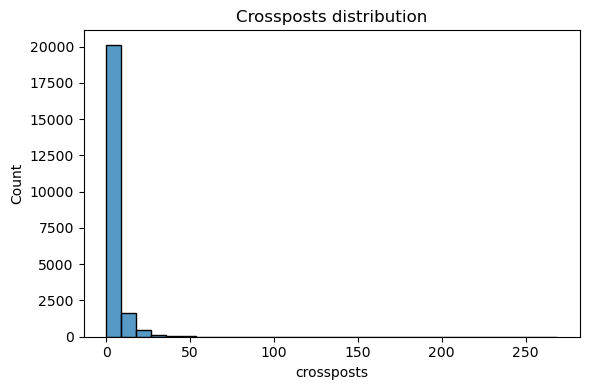

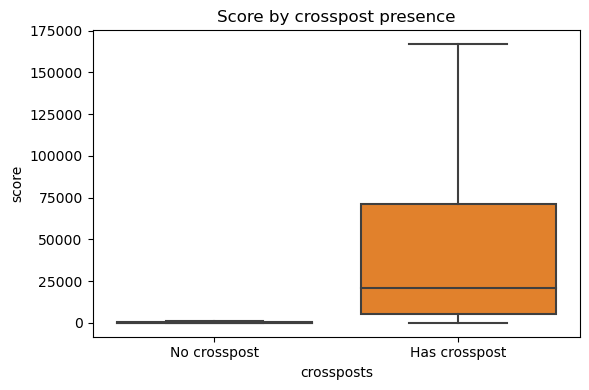

In [48]:
#Q9. Crossposts: how common, and do they change engagement?
if "crossposts" in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df["crossposts"].fillna(0), bins=30)
    plt.title("Crossposts distribution")
    plt.tight_layout(); plt.show()

    if "score" in df.columns:
        has_xp = (df["crossposts"].fillna(0) > 0)
        plt.figure(figsize=(6,4))
        sns.boxplot(x=has_xp, y=df["score"], showfliers=False)
        plt.title("Score by crosspost presence")
        plt.xticks([0,1], ["No crosspost","Has crosspost"])
        plt.tight_layout(); plt.show()


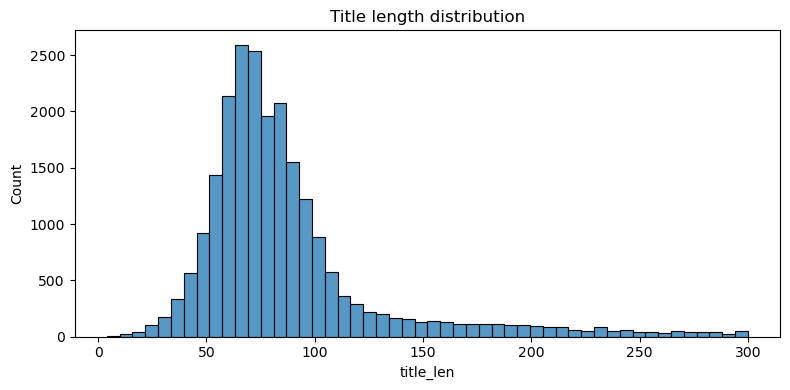

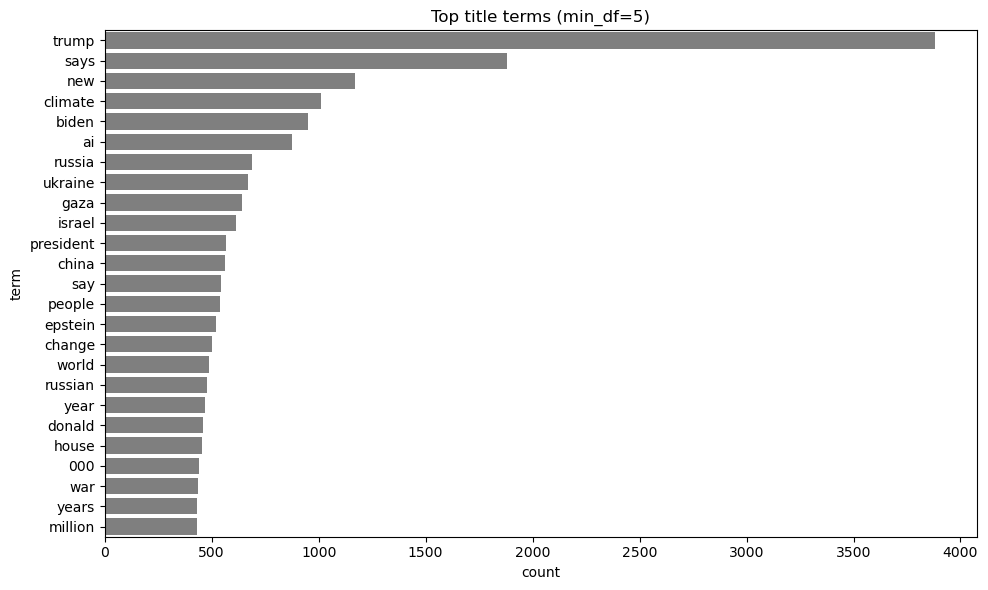

In [49]:
#Q10. Do titles show simple patterns?
from sklearn.feature_extraction.text import CountVectorizer

if "title" in df.columns:
    df["title_len"] = df["title"].astype(str).str.len()
    plt.figure(figsize=(8,4))
    sns.histplot(df["title_len"], bins=50)
    plt.title("Title length distribution")
    plt.tight_layout(); plt.show()

    titles = df["title"].dropna().astype(str)
    if len(titles) > 0:
        vec = CountVectorizer(stop_words="english", min_df=5)
        X = vec.fit_transform(titles)
        vocab = np.array(vec.get_feature_names_out())
        freqs = np.asarray(X.sum(axis=0)).ravel()
        top = freqs.argsort()[::-1][:25]
        top_terms = pd.DataFrame({"term": vocab[top], "count": freqs[top]})

        plt.figure(figsize=(10,6))
        sns.barplot(data=top_terms, y="term", x="count", color="tab:gray")
        plt.title("Top title terms (min_df=5)")
        plt.tight_layout(); plt.show()


In [51]:
#Q11. Which weekdays have the highest median score and comments?
q11 = (df.groupby("weekday")
         .agg(med_score=("score","median"),
              med_comments=("comments","median"),
              n=("id","count"))
         .reset_index()
         .sort_values("med_score", ascending=False))
q11


,weekday,med_score,med_comments,n
3,Sunday,768.0,124.0,2547
2,Saturday,649.0,114.0,2467
0,Friday,517.0,112.0,3355
1,Monday,503.0,92.0,3440
4,Thursday,496.0,91.0,3539
5,Tuesday,460.0,93.0,3555
6,Wednesday,420.5,100.5,3594


In [52]:
#Q12. What hours of day yield the highest median score?
q12 = (df.groupby("hour")
         .agg(med_score=("score","median"),
              med_comments=("comments","median"),
              n=("id","count"))
         .reset_index()
         .sort_values("med_score", ascending=False))
q12.head(10)


,hour,med_score,med_comments,n
0,0,1326.5,147.5,794
11,11,1325.5,134.0,1088
22,22,871.0,132.5,924
13,13,857.5,117.0,1542
23,23,762.0,126.0,905
18,18,747.5,114.5,1276
21,21,743.0,121.0,1079
10,10,702.0,97.0,889
14,14,681.0,109.5,1426
12,12,665.5,106.0,1366


In [53]:
#Q13. Is “Unflair” concentrated in specific subreddits?
q13 = (df.assign(flair_missing=df["flair_filled"].eq("Unflair"))
         .groupby("subreddit")
         .agg(n=("id","count"), miss_rate=("flair_missing","mean"))
         .query("n >= 50")
         .sort_values("miss_rate", ascending=False)
         .head(20))
q13


,n,miss_rate
subreddit,,
environment,4024,0.999006
news,3463,0.909616
politics,5687,0.716195
worldnews,4655,0.382599
technology,4668,0.069837


In [54]:
#Q14. Within top subreddits, which flairs perform best?
top_subs = (df["subreddit"].value_counts().head(5).index.tolist())
q14 = (df[df["subreddit"].isin(top_subs)]
         .groupby(["subreddit","flair_filled"])
         .agg(n=("id","count"), med_score=("score","median"))
         .query("n >= 20")
         .sort_values(["subreddit","med_score"], ascending=[True, False]))
q14.head(50)


n  med_score
subreddit   flair_filled                            
environment Unflair                  4020      100.0
news        Unflair                  3150     8755.5
            Soft paywall              172     1813.5
politics    Megathread                 36    75439.0
            Site Altered Headline      69    31113.0
            Unflair                  4073      246.0
            Soft Paywall             1305      161.0
            Paywall                   127       36.0
            Discussion                 34        0.0
technology  Net Neutrality             95    49662.0
            Misleading                 44    19401.0
            Social Media              335    12996.0
            Politics                  322     7420.0
            Business                  861     5655.0
            ADBLOCK WARNING            37     2525.0
            Society                   261     2068.0
            Privacy                   155     1627.0
            Transportation            187     1037.0
            Security                  253      474.0
            Networking/Telecom         77      410.0
            Biotechnology              69      393.0
            Energy                    109      355.0
            Software                  206      101.0
            Space                     115       26.0
            Artificial Intelligence   743       17.0
            Unflair                   326       13.0
            Hardware                  244       12.5
            Pure Tech                  32        6.0
            Robotics/Automation        54        3.5
worldnews   Hong Kong                  21    94666.0
            COVID-19                  100    92114.5
            Russia                     33    87313.0
            Trump                     111    84636.0
            North Korea                32    13011.0
            Russia/Ukraine           1149     5377.0
            Unflair                  1781      564.0
            India/Pakistan             30      220.5
            Dynamic Paywall            74      129.0
            Behind Soft Paywall       176       88.0
            Israel/Palestine          966       19.0

In [55]:
#Q15. Are link or self posts more common among top scores?
q15 = (df.assign(score_decile=pd.qcut(df["score"].rank(method="first"), 10, labels=False))
         .groupby(["score_decile","is_self"])
         .size()
         .unstack(fill_value=0))
q15


is_self,False,True
score_decile,,
0,2236,14
1,2146,104
2,2217,32
3,2223,27
4,2226,24
5,2232,17
6,2245,5
7,2244,5
8,2226,24


In [56]:
#Q16. Which external domains are associated with higher median scores?
internal = df["domain"].astype(str).str.contains("reddit.com|redd.it", na=False)
q16 = (df[~internal]
         .groupby("domain")
         .agg(n=("id","count"), med_score=("score","median"), med_comments=("comments","median"))
         .query("n >= 20")
         .sort_values("med_score", ascending=False)
         .head(25))
q16


,n,med_score,med_comments
domain,,,
theweek.com,20,72386.5,3817.5
businessinsider.com,362,48341.5,1926.5
vice.com,75,44759.0,1619.0
deadline.com,23,33435.0,1371.0
vanityfair.com,26,30433.5,1146.0
nj.com,35,29984.0,1529.0
independent.co.uk,499,20544.0,1218.0
9to5mac.com,22,19268.0,1221.0
newsweek.com,464,18721.0,963.0


In [57]:
#Q17. Do crossposts align with higher engagement overall and by subreddit?
overall = (df.assign(has_cross=(df["crossposts"].fillna(0) > 0))
             .groupby("has_cross")
             .agg(n=("id","count"), med_score=("score","median"), med_comments=("comments","median")))
by_sub = (df.assign(has_cross=(df["crossposts"].fillna(0) > 0))
            .groupby(["subreddit","has_cross"])
            .agg(n=("id","count"), med_score=("score","median"))
            .query("n >= 20")
            .reset_index()
            .sort_values(["subreddit","med_score"], ascending=[True, False]))
overall, by_sub.head(30)


(               n  med_score  med_comments
 has_cross                                
 False      13314       31.0          31.0
 True        9183    20643.0        1222.0,
      subreddit  has_cross     n  med_score
 1  environment       True   938     3760.0
 0  environment      False  3086       27.0
 3         news       True  2039    24104.0
 2         news      False  1424      143.0
 5     politics       True  2416    27790.0
 4     politics      False  3271       27.0
 7   technology       True  1754    22937.5
 6   technology      False  2914       17.0
 9    worldnews       True  2036    20680.5
 8    worldnews      False  2619       49.0)

# Suggestions and recommendations

- Post timing
  - Focus on the top 2-3 hours and weekdays with the highest median score and comments, as identified in the by_hour and by_weekday summaries; schedule posts and moderation around these windows. 
  - If weekday-hour peaks differ by subreddit, tailor timing per community rather than one-size-fits-all. 

- Flair hygiene
  - Keep using flair_filled and monitor flair missingness by subreddit; if a few subreddits drive most missing flairs, consider targeted fixes or exclude “Unflair” from flair-performance comparisons to avoid misattribution. 
  - For reporting, highlight “Unflair” proportion to make missingness visible and avoid false conclusions about specific flairs. 

- Content format
  - Compare self vs. link medians within top subreddits; if link posts win in news-heavy subs but self posts do better elsewhere, adopt a subreddit-specific format strategy. 
  - If title length bins show a sweet spot, incorporate guidelines for headline length in content playbooks. 

- Source domains
  - Promote or prioritize domains with consistently above-median scores; consider curating allowlists for high-quality sources and downweighting low-performing ones.
  - Track domain mix over time to detect shifts in audience interest or news cycles; adjust sourcing accordingly. 

- Crossposting
  - If crossposts correlate with higher medians, develop a crossposting strategy across thematically aligned subreddits; if not, deprioritize crossposting except for exceptional content.

- Language patterns
  - Use token enrichment in top-quartile posts to create title heuristics (e.g., include concrete entities, outcomes, or numbers); validate heuristics periodically to avoid overfitting to short-term cycles. 

- Engagement skew
  - If a small fraction of posts drives most score, invest in identifying traits of top decile content (domain, flair, timing) and replicate those patterns deliberately. 

- Reporting discipline
  - Keep raw vs. engineered features (e.g., flair vs. flair_filled) in outputs and document transformations; this preserves auditability and supports iteration as new data arrives. 

- Caution on interpretation
  - Treat upvote_ratio as descriptive; it is a share, not a count, and can be noisy across endpoints—avoid using it alone for causal claims. 

These additions align with a question-and-answer EDA workflow and end with practical actions, mirroring the “insights and recommendations” style used in many EDA reports. 